[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/multiple-schemas.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239434-lesson-3-multiple-schemas)

# Multiple Schemas

## Review

We just covered state schema and reducers.

Typically, all graph nodes communicate with a single schema. 

Also, this single schema contains the graph's input and output keys / channels.

## Goals

But, there are cases where we may want a bit more control over this:

* Internal nodes may pass information that is *not required* in the graph's input / output.

* We may also want to use different input / output schemas for the graph. The output might, for example, only contain a single relevant output key.

We'll discuss a few ways to customize graphs with multiple schemas.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Private State

First, let's cover the case of passing [private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) between nodes.

#### This is useful for anything needed as part of the intermediate working logic of the graph, but not relevant for the overall graph input or output.

We'll define an `OverallState` and a `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

In [4]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict): # for all the nodes, global state
    foo: int

class PrivateState(TypedDict): # for node_1 logic only, intermediate state
    baz: int

def node_1(state: OverallState) -> PrivateState: # node_1 receives global state, returns to intermediate state only
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState: # node_2 receives intermediate state, returns to global state
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View - i'm getting a 500 error from mermaid API, so I'm skipping this step
#display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"foo" : 1})
# The graph starts with foo=1, node 1 turns it into baz=2 (foo=1 from global state, +1), 
#  and node 2 turns into foo=3 by using baz=2 from intermediate state, +1

---Node 1---
---Node 2---


{'foo': 3}

`baz` is only included in `PrivateState`.

`node_2` uses `PrivateState` as input, but writes out to `OverallState`.

So, we can see that `baz` is excluded from the graph output because it is not in `OverallState`.

## Input / Output Schema

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema. 

However, it is also possible to [define explicit input and output schemas for a graph](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

Often, in these cases, we define an "internal" schema that contains *all* keys relevant to graph operations.

But, we use specific `input` and `output` schemas to constrain the input and output.

First, let's just run the graph with a single schema.

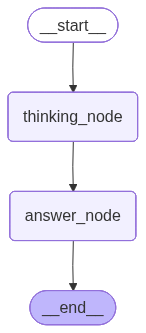

In [6]:
# Using a unique state (OverallState)
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: OverallState):
    return {"answer": "bye", "notes": "... his name is Lance"}

def answer_node(state: OverallState):
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Notice that the output of invoke contains all keys in `OverallState`. 

In [7]:
graph.invoke({"question":"hi"})

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his name is Lance'}

Now, let's use a specific `input` and `output` schema with our graph.

##### Here, `input` / `output` schemas perform *filtering* on what keys are permitted on the input and output of the graph. 


In addition, we can use a type hint `state: InputState` to specify the input schema of each of our nodes.

> Think of input and output schemas as filters on the global state, that specify what we want for input and what we want for output. So we can have a global state, but only pass certain keys to the input and output of the graph, only what we want to show to the user in the output, for example.

This is important when the graph is using multiple schemas.

We use type hints below to, for example, show that the output of `answer_node` will be filtered to `OutputState`. 

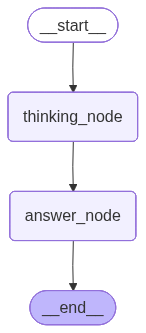

{'answer': 'bye Lance'}

In [ ]:
# Using different states for input and output
class InputState(TypedDict): #input -Ç constrains to only the question!
    question: str   

class OutputState(TypedDict): #output -> constrains to only the answer!
    answer: str

class OverallState(TypedDict): #global
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

We can see the `output` schema constrains the output to only the `answer` key.
> only 'answer' is sent to the user!